# **Adversarial Settings**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### In Adversarial Settings we generalize the process generating rewards. Instead of being sampled from a probability distribution, rewards are chosen by an adversary that can observe the bandit algorithm is facing.

## **The Adversarial Expert Setting**

### In Expert settings, at each round, an agent chooses an arm and incurs its loss, but can observe the losses of all the other arms.

### Thus, there is no exploration-exploitation trade-off dilemma, since exploration is pointless when all information is available.

In [2]:
class AdversarialExpertEnvironment:
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        l_t = self.loss_sequence[self.t, :] ## we return the whole loss vector
        self.t+=1 
        return l_t

In [3]:
# I see the algorithm, then decide an arbitrary sequence of rewards:
loss_seq = np.array([[0,1,0],[1,0,1],[1,1,1],[1,0,1],[0,1,0],[0,1,1],[0,0,0],[0,1,0],[1,1,0],[0,0,1]])
loss_seq.shape

(10, 3)

In [4]:
env = AdversarialExpertEnvironment(loss_seq)
env.t, env.round(), env.t

(0, array([0, 1, 0]), 1)

### Of course, the Adversarial setting generalizes the Stochastic setting, since the adversary is free to choose to sample the rewards from a probability distribution, thus any Stochastic MAB is also a special instance of Adversarial MAB.

### The notion of regret change its meaning, the clairvoyant is not the agent always choosing the best action at any moment, but the agent always pulling the arm having the best cumulative reward at the end.

In [5]:
print(f'Best achievable cumulative loss: {loss_seq.min(axis=1).sum()}')
print(f'Best achievable cumulative loss when always pulling the same arm: {loss_seq.sum(axis=0).min()}')

Best achievable cumulative loss: 1
Best achievable cumulative loss when always pulling the same arm: 4


### We will compare to the second.

### We need to define a new clairvoyant: _Best arm in hindsight_.

In [6]:
best_arm = np.argmin(loss_seq.sum(axis=0))
print(f'The best arm in hindsight is {best_arm}')

The best arm in hindsight is 0


In [7]:
clairvoyant_losses = loss_seq[:, best_arm]
clairvoyant_losses

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

## **The Hedge algorithm**

In [8]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

### Due to practical reasons, we generate the losses using a probability distribution. However, in principle, we would be free to choose any sequence we'd like.

In [9]:
T = 10000
K = 3
loss_seq = np.zeros((T, K))
np.random.seed(17)
loss_seq[:,0] = np.random.binomial(n=1, p=0.7, size=T)
loss_seq[:,1] = np.random.binomial(n=1, p=0.5, size=T)
loss_seq[:,2] = np.random.binomial(n=1, p=0.25, size=T)

### We distinguish two ways to computed regret: actual regret and regret in expectation.

### **Important Remark**: in adversarial settings, the expectation on regret is only taken w.r.t. to the randomness of the algorithm, since by definition the sequence of losses is not stochastic.

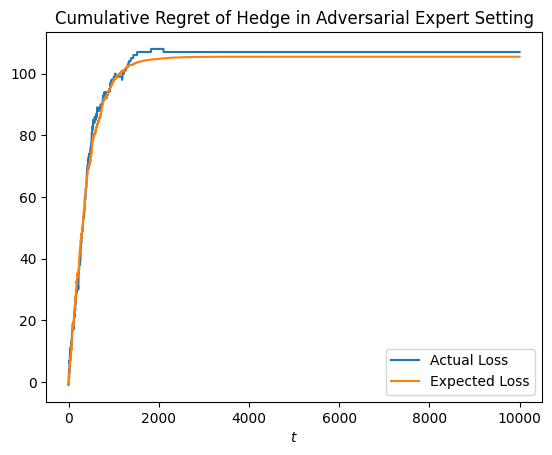

In [10]:
learning_rate = np.sqrt(np.log(K)/T) # we set the learning rate as prescribed by the theory

agent = HedgeAgent(K, learning_rate)
env = AdversarialExpertEnvironment(loss_seq)

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

# we log to different cumulative losses for the agent
agent_losses = np.array([])
expected_agent_losses = np.array([])

for t in range(T):
    a_t = agent.pull_arm()
    l_t = env.round()
    agent.update(l_t)
    # logging
    agent_losses = np.append(agent_losses, l_t[a_t])
    expected_agent_losses = np.append(expected_agent_losses, np.dot(l_t, agent.x_t))

plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Loss')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Loss')
plt.title('Cumulative Regret of Hedge in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [11]:
print(f'Best arm in hindsight: {best_arm}')
print(f'Final allocation :{agent.x_t}') # the best arm is the one having more weight

Best arm in hindsight: 2
Final allocation :[2.20201475e-21 5.41612728e-12 1.00000000e+00]


In [12]:
print(f'Theoretical bound: {2*np.sqrt(T*np.log(K))}')
print(f'Actual Total Regret {sum(agent_losses)-sum(clairvoyant_losses)}') 
print(f'Expected Total Regret {sum(expected_agent_losses)-sum(clairvoyant_losses)}') 


Theoretical bound: 209.629414793641
Actual Total Regret 107.0
Expected Total Regret 105.46378244425341


## **The Adversarial Bandit Setting**

### In Bandit Settings, the agent chooses one arm and can only observe the loss associated to that single arm. Thus, the feedback received from the environment is limited. This problem is intrinsically harder than the expert setting, due to the more limited information available.

In [13]:
class AdversarialBanditEnvironment:
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self, a_t): # we need to receive a specific arm
        l_t = self.loss_sequence[self.t, a_t] ## we return only the loss corresponding to the chosen arm
        self.t+=1 
        return l_t

### As before, the sequence of losses is arbitrary.

In [14]:
# I see the algorithm, then decide the sequence of rewards:
loss_seq = np.array([[0,1,0],[1,0,1],[1,1,1],[1,0,1],[0,1,0],[0,1,1],[0,0,0],[0,1,0],[1,1,0],[0,0,1]])
env = AdversarialBanditEnvironment(loss_seq)
env.t, env.round(0), env.t

(0, 0, 1)

### As before, the regret is computed w.r.t. the best arm in hindsight

In [15]:
print(f'Best achievable cumulative loss: {loss_seq.min(axis=1).sum()}')
print(f'Best achievable cumulative loss when always pulling the same arm: {loss_seq.sum(axis=0).min()}')

Best achievable cumulative loss: 1
Best achievable cumulative loss when always pulling the same arm: 4


### We will compare to the second.

### However, the problem is now harder, since we can only observe the feedback associated to the arm we choose. Thus, we need to deal with the exploration-exploitation trade-off.

## **Extending Hedge to a Bandit Setting: the EXP3 Algorithm**

In [16]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [17]:
T = 10000
K = 3
loss_seq = np.zeros((T, K))
np.random.seed(17)
loss_seq[:,0] = np.random.binomial(n=1, p=0.7, size=T)
loss_seq[:,1] = np.random.binomial(n=1, p=0.5, size=T)
loss_seq[:,2] = np.random.binomial(n=1, p=0.25, size=T)

### Again, we can compute the received losses in two ways: actual and expected. Note that in bandit settings, differently from experts, the expected loss cannot be computed in practice, since it would require to know all the losses associated to every arm.

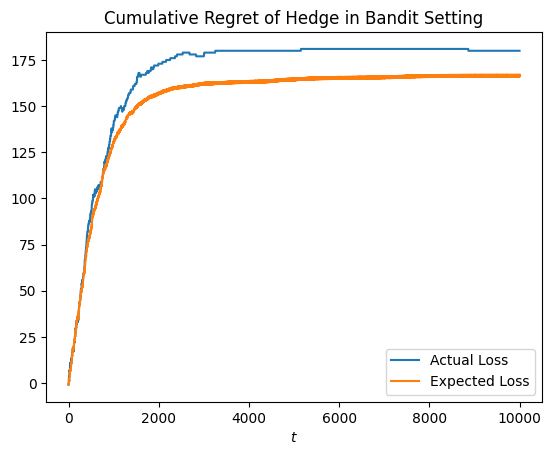

In [18]:
learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

agent = EXP3Agent(K, learning_rate)
env = AdversarialBanditEnvironment(loss_seq)

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

agent_losses = np.array([])
expected_agent_losses = np.array([])
for t in range(T):
    a_t = agent.pull_arm()
    l_t = env.round(a_t)
    agent.update(l_t)
    # logging
    agent_losses = np.append(agent_losses, l_t)
    expected_agent_losses = np.append(expected_agent_losses,
                                    np.dot(agent.x_t,
                                           env.loss_sequence[t-1,:]))

plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Loss')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Loss')
plt.title('Cumulative Regret of Hedge in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Remark: the agent only observes the loss associated to the chosen arm, expected loss cannot be computed without knowing the losses from all arms (like in the expert setting). Thus, the algorithm only reacts based on the actual loss incurred.

In [19]:
print(f'Best arm in hindsight: {best_arm}')
print(f'Final allocation :{agent.x_t}') # the best arm is the one having more weight

Best arm in hindsight: 2
Final allocation :[2.94641974e-08 6.99443661e-06 9.99992976e-01]


In [20]:
print(f'Theoretical bound: {2*np.sqrt(T*K)}') # The theoretical bound has worsen dependence on K w.r.t. expert setting (from log(K) to sqrt(K))
print(f'Actual Total Regret {sum(agent_losses)-sum(clairvoyant_losses)}') 

Theoretical bound: 346.41016151377545
Actual Total Regret 180.0


### We can quantify the uncertainty on expected regret, where the only uncertainty source is algorithm's randomization.

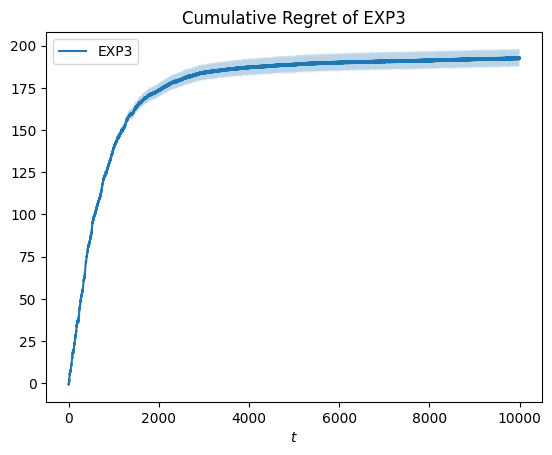

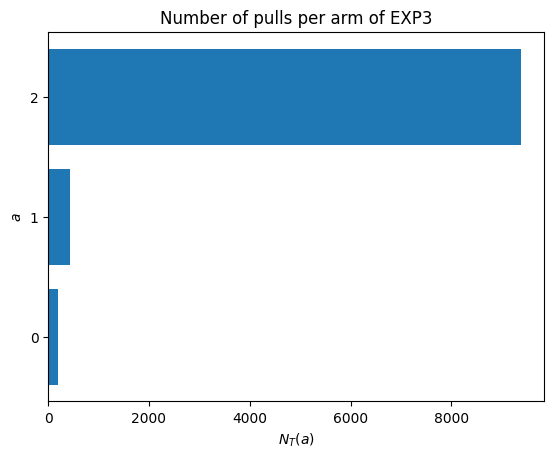

In [21]:
learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

n_trials = 20

exp3_regret_per_trial = []
# we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
for trial in range(n_trials):
    agent = EXP3Agent(K, learning_rate)
    env = AdversarialBanditEnvironment(loss_seq)
    
    expected_agent_losses = np.array([])
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = env.round(a_t)
        agent.update(l_t)
        # logging
        expected_agent_losses = np.append(expected_agent_losses,
                                        np.dot(agent.x_t,
                                        env.loss_sequence[t-1,:]))

    cumulative_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)
    exp3_regret_per_trial.append(cumulative_regret)

exp3_regret_per_trial = np.array(exp3_regret_per_trial)

exp3_average_regret = exp3_regret_per_trial.mean(axis=0)
exp3_regret_sd = exp3_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=agent.N_pulls)
plt.title('Number of pulls per arm of EXP3')
plt.ylabel('$a$')
plt.xlabel('$N_T(a)$')
plt.show()